In [69]:
import win32com.client
import time
import pandas as pd
import numpy as np
import time
from glob import glob

In [2]:
# THIS ONLY HAD TO BE RUN ONCE
# Build 38 and 200 kHz
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]
line200 = [45.65, 42.9, 45.65, 42.9, 47.5] # range 1.5
line38 = [43.65, 39.8, 42.15, 40.4, 43] # range 3.5 or below ringdown if shallower

for i in range(5):
    print('Working on fileset '+str(i))
    files = filesets[i]
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    ct = 0
    for file in files:
        start = time.time()
        EvFile = EvApp.OpenFile(file)
        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile('E:\\MooredEchosounders\\data\\EVTemplates\\wbatEmptyCal.ecs')

        EvFile.Import('E:\\MooredEchosounders\\data\\EVTemplates\\WBAT_SawadaCorrection.EV')
        VarParent1 = EvFile.Variables.FindByName("38 kHz Sv in cell")
        VarChild1 = EvFile.Variables.FindByName("Nv threshold bitmap")
        VarNew = EvFile.Variables.FindByName("Fish per volume in cell corr")
        VarNew.SetOperand(1, VarParent1)
        VarChild1.SetOperand(1, VarNew)

        EvVar = EvFile.Transducers.FindByName('Fileset 1: T1 (channel 2)')
        EvVar.BeamRotation = 180
        EvVar.Elevation = 180

        EvVar = EvFile.Transducers.FindByName('Fileset 1: T1 (channel 3)')
        EvVar.BeamRotation = 180
        EvVar.Elevation = 180

        EvNewLine = EvFile.Lines.CreateFixedDepth(line200[i])
        EvNewLine.Name = 'transducerExclusionLine200'

        EvNewLine = EvFile.Lines.CreateFixedDepth(line38[i])
        EvNewLine.Name = 'transducerExclusionLine38'
        EvFile.Save()
        EvFile.Close()
        print('File Saved. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
        ct+=1
    EvApp.Quit()

Working on fileset 0
File Saved. Total time: 0m 5s


In [41]:
def evExporterMooringMod(evFiles,year,daft,depth,calFile): # where evFiles is a list of *.EV files (with complete path)
    print(year,' ',daft)
    channels = {70:'channel 1',38:'channel 2',200:'channel 3'}
    newFiles = []
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    EvApp.Minimize()
    for file in evFiles:
        start = time.time()
        EvFile = EvApp.OpenFile(file)

        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile(calFile)

        for freq in [70,38,200]:
            EvVar = EvFile.Variables.FindByName('Fileset 1: Sv pings T1 ('+channels[freq]+')')
            EvUpperLine = EvFile.Lines.FindByName('surfaceExclusionLine70');
            EvLowerLine = EvFile.Lines.FindByName('transducerExclusionLine'+str(freq));
            regionName = 'WaterColumn_'+str(freq)
            Region1 = EvVar.CreateLineRelativeRegion(regionName,EvUpperLine,EvLowerLine);
            RegClassObj = EvFile.RegionClasses.FindByName('WaterColumn');
            EvFile.Regions.FindByName(regionName).RegionClass = RegClassObj;
            EvFile.Regions.FindByName(regionName).RegionType = 1# 1 is for anlysis

            EvVar.Properties.Data.ApplyMinimumThreshold= 0;
            EvVar.Properties.Data.MinimumThreshold= -70;
            EvVar.Properties.Data.ApplyMaximumThreshold= 0;
            EvVar.Properties.Data.MaximumThreshold=-30;

            #  set grid settings for range in m and distance in nmi as defined by VL
            EvVar.Properties.Grid.SetDepthRangeGrid(1,depth)
            EvVar.Properties.Grid.SetTimeDistanceGrid(1, 60)# 1 is for time, 3 is for nmi

            # set exclusion lines
            EvVar.Properties.Analysis.ExcludeAboveLine = 'surfaceExclusionLine70'
            EvVar.Properties.Analysis.ExcludeBelowLine = 'transducerExclusionLine'+str(freq)

            ExportFileName='E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\'+str(depth)+'m\\'+str(freq)+'kHz-'+daft + '-'+\
                                 str(depth)+'m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv'
            exporttest = EvVar.ExportIntegrationByRegionsByCellsAll(ExportFileName);
            if exporttest:
                print('File '+str(freq)+' Exported. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
                newFiles.append('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\'+str(depth)+'m\\'+str(freq)+'kHz-'+daft + '-'+\
                                 str(depth)+'m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
            else:
                print('File Export Failed')

        EvFile.Close()
    EvApp.Quit()
    print('Done')
    return newFiles

In [2]:
def evExporterMooringTracks(evFiles,year,daft,calFile): # where evFiles is a list of *.EV files (with complete path)
    print(year,' ',daft)
    trackExportItems = ['Direction_horizontal','Direction_vertical','Distance_2D_unsmoothed','Distance_3D_unsmoothed','Fish_track_change_in_depth','Fish_track_change_in_range',
        'Speed_2D_max_unsmoothed','Speed_2D_mean_unsmoothed','Speed_4D_max_unsmoothed','Speed_4D_mean_unsmoothed','Time_in_beam','Tortuosity_2D','Tortuosity_3D',
        'Num_targets','Target_depth_max','Target_depth_mean','Target_depth_min','Target_length_mean','Target_range_max','Target_range_mean','Target_range_min',
        'TS_max','TS_mean','TS_min']
    newFiles = []
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    EvApp.Minimize()
    for file in evFiles:
        start = time.time()
        EvFile = EvApp.OpenFile(file)        
        FTProps = EvFile.Properties.FishTracking
        FTProps.DataDimensions = 4
        FTProps.Alpha.MajorAxis = 0.6
        FTProps.Alpha.MinorAxis = 0.6
        FTProps.Alpha.Range = 0.6
        FTProps.Beta.MajorAxis = 0.0
        FTProps.Beta.MinorAxis = 0.0
        FTProps.Beta.Range = 0.0
        FTProps.ExclusionDistance.MajorAxis = 0.7
        FTProps.ExclusionDistance.MinorAxis = 0.7
        FTProps.ExclusionDistance.Range = 0.3
        FTProps.MissedPingExpansion.MajorAxis = 10
        FTProps.MissedPingExpansion.MinorAxis = 10
        FTProps.MissedPingExpansion.Range = 10

        FTProps.Weights.MajorAxis = 30
        FTProps.Weights.MinorAxis = 30
        FTProps.Weights.Range = 30
        FTProps.Weights.TS = 30
        FTProps.Weights.PingGap = 10

        FTProps.MinimumTargets = 5
        FTProps.MinimumPings = 5
        FTProps.MaximumGap = 5

        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile(calFile)
        EvVar = EvFile.Variables.FindByName('38 kHz single targets')  #'38 kHz Nv filtered single targets' for sawada, actually 70 kHz
        EvVar.Properties.Analysis.ExcludeAboveLine = 'surfaceExclusionLine70'
        EvVar.Properties.Analysis.ExcludeBelowLine = 'transducerExclusionLine70'
        EvVar.DetectFishTracks('fishTracks');
        EvFile.Properties.Export.Mode=1

        for item in trackExportItems:
            EvFile.Properties.Export.Variables.Item(item).Enabled=1
        EvFile.Properties.Export
        exporttest = EvVar.ExportFishTracksByRegionsAll('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\tracks\\FishTracks4D-'+daft + '-'+\
                                '5m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
        if exporttest:
            print('File Exported. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
            newFiles.append('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\tracks\\FishTracks4D-'+daft + '-'+\
                                '5m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
        EvFile.Close()
    EvApp.Quit()
    print('Done')
    return newFiles

In [ ]:
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]

depth = 1

year = '2018'
daft = 'DAFT1'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C11_17_18.ecs'
a = evExporterMooringMod(filesets[0],year,daft,depth,calFile)

year = '2018'
daft = 'DAFT2'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C1_17_18.ecs'
a = evExporterMooringMod(filesets[1],year,daft,depth,calFile)

year = '2019'
daft = 'DAFT1'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C11_18_19.ecs'
a = evExporterMooringMod(filesets[2],year,daft,depth,calFile)

year = '2019'
daft = 'DAFT2'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C1_18_19.ecs'
a = evExporterMooringMod(filesets[3],year,daft,depth,calFile)

year = '2019'
daft = 'DAFT3'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C4_18_19.ecs'
a = evExporterMooringMod(filesets[4],year,daft,depth,calFile)

In [ ]:
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]

depth = 1

year = '2018'
daft = 'DAFT1'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C11_17_18.ecs'
a = evExporterMooringTracks(filesets[0],year,daft,calFile)

year = '2018'
daft = 'DAFT2'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C1_17_18.ecs'
a = evExporterMooringTracks(filesets[1],year,daft,calFile)

year = '2019'
daft = 'DAFT1'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C11_18_19.ecs'
a = evExporterMooringTracks(filesets[2],year,daft,calFile)

year = '2019'
daft = 'DAFT2'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C1_18_19.ecs'
a = evExporterMooringTracks(filesets[3],year,daft,calFile)

year = '2019'
daft = 'DAFT3'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C4_18_19.ecs'
a = evExporterMooringTracks(filesets[4],year,daft,calFile)

# Reading exports

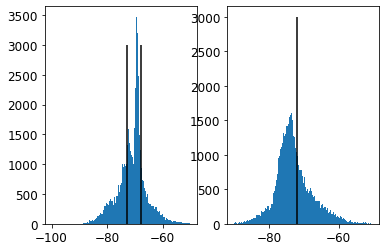

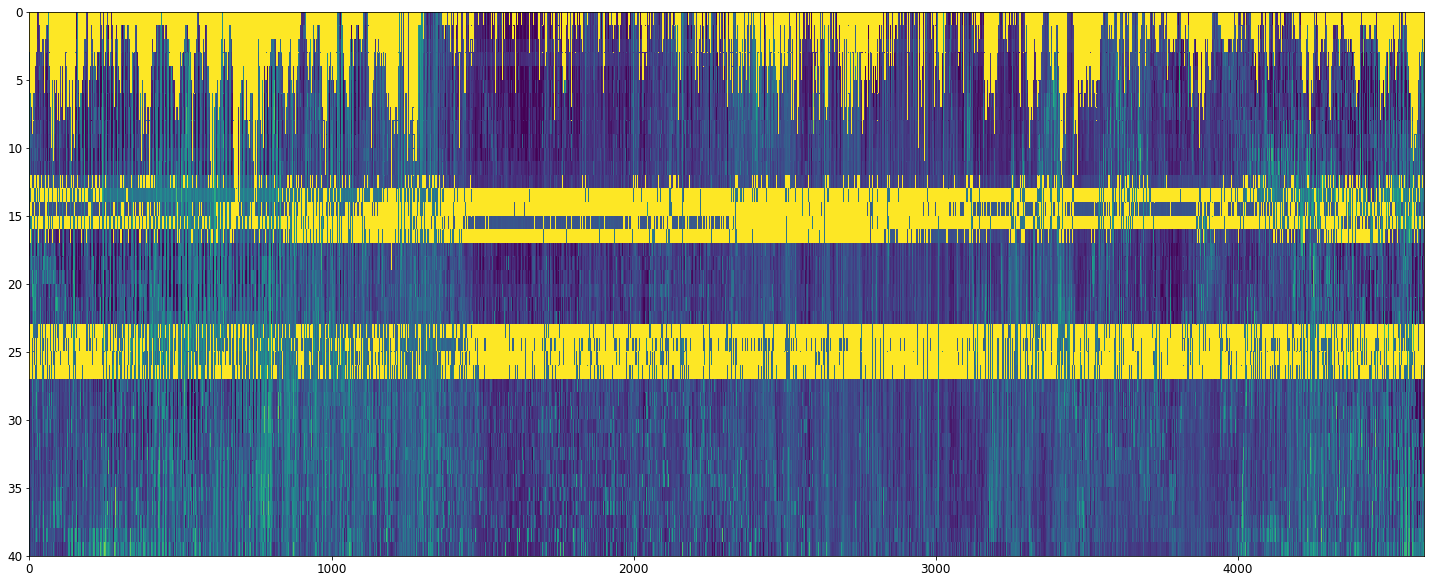

In [112]:
dfD1_200 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/DAFT2/exports/1m/200*.csv')))
plt.subplot(121)
plt.hist(dfD1_200[(dfD1_200.layer.isin([16,17,18,19,20]))].Sv,bins=np.arange(-100,-50,.25));
plt.vlines(-68,0,3000,'k')
plt.vlines(-73,0,3000,'k')
plt.subplot(122)
plt.hist(dfD1_200[(dfD1_200.layer.isin([27,28,29,30]))].Sv,bins=np.arange(-90,-50,.25));
plt.vlines(-72,0,3000,'k')

dfD1_200['wakeup'] = pd.to_datetime(dfD1_200.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
dfD1_200_2 = dfD1_200
dfD1_200_2.loc[(dfD1_200_2.layer.isin([16,17,18,19,20]))&(dfD1_200_2.Sv <-68)&(dfD1_200_2.Sv >-73),'Sv']=np.nan
dfD1_200_2.loc[(dfD1_200_2.layer.isin([27,28,29,30]))&(dfD1_200_2.Sv <-72),'Sv']=np.nan

a = pd.pivot_table(dfD1_200_2, values="Sv",index=["layer"], columns=["wakeup"], fill_value=0)
fig, ax = plt.subplots(figsize=(25,10))
heatmap = ax.pcolormesh(a, cmap=plt.cm.viridis,vmin=-90, vmax=-30)
ax.invert_yaxis()

In [321]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.dates as mdates
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.pyplot as plt

def daftPivot(daft,var):
    dfD1_70 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
    dfD1_38 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
    dfD1_200 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
    dfD1_70['wakeup'] = pd.to_datetime(dfD1_70.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    dfD1_38['wakeup'] = pd.to_datetime(dfD1_38.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    dfD1_200['wakeup'] = pd.to_datetime(dfD1_200.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    
    if daft == 'DAFT2':
        dfD1_200.loc[(dfD1_200.datetime>pd.to_datetime('2018-08-15 00:00:00'))&(dfD1_200.layer.isin([16,17,18,19,20]))&(dfD1_200.Sv <-68),var]=np.nan # One additional argument... &(dfD1_200.Sv >-73)
        dfD1_200.loc[(dfD1_200.datetime>pd.to_datetime('2018-08-15 00:00:00'))&(dfD1_200.layer.isin([27,28,29,30]))&(dfD1_200.Sv <-72),var]=np.nan

    piv70 = padDates(dfD1_70,var)
    piv38 = padDates(dfD1_38,var)
    piv200 = padDates(dfD1_200,var)
    return piv70, piv38, piv200

def padDates(df,var):
    a = pd.date_range(start = '2017-8-7', end='2019-09-06', freq='2H')
    b = pd.DataFrame({'datetime':a[~a.isin(df.wakeup)],'layer':1.0,'test':1})
    b = b.set_index('datetime')
    b['wakeup'] = pd.to_datetime(b.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    c = pd.pivot_table(b, values='test',index=["layer"], columns=["wakeup"], fill_value=np.nan)
    d = pd.pivot_table(df, values=var,index=["layer"], columns=["wakeup"], fill_value=np.nan)
    d = d.append(c)
    d = d[d.index!=1]
    d = d.sort_index(axis='columns', level='wakeup')
    return d

Text(0, 0.5, '38 kHz Mean Sv')

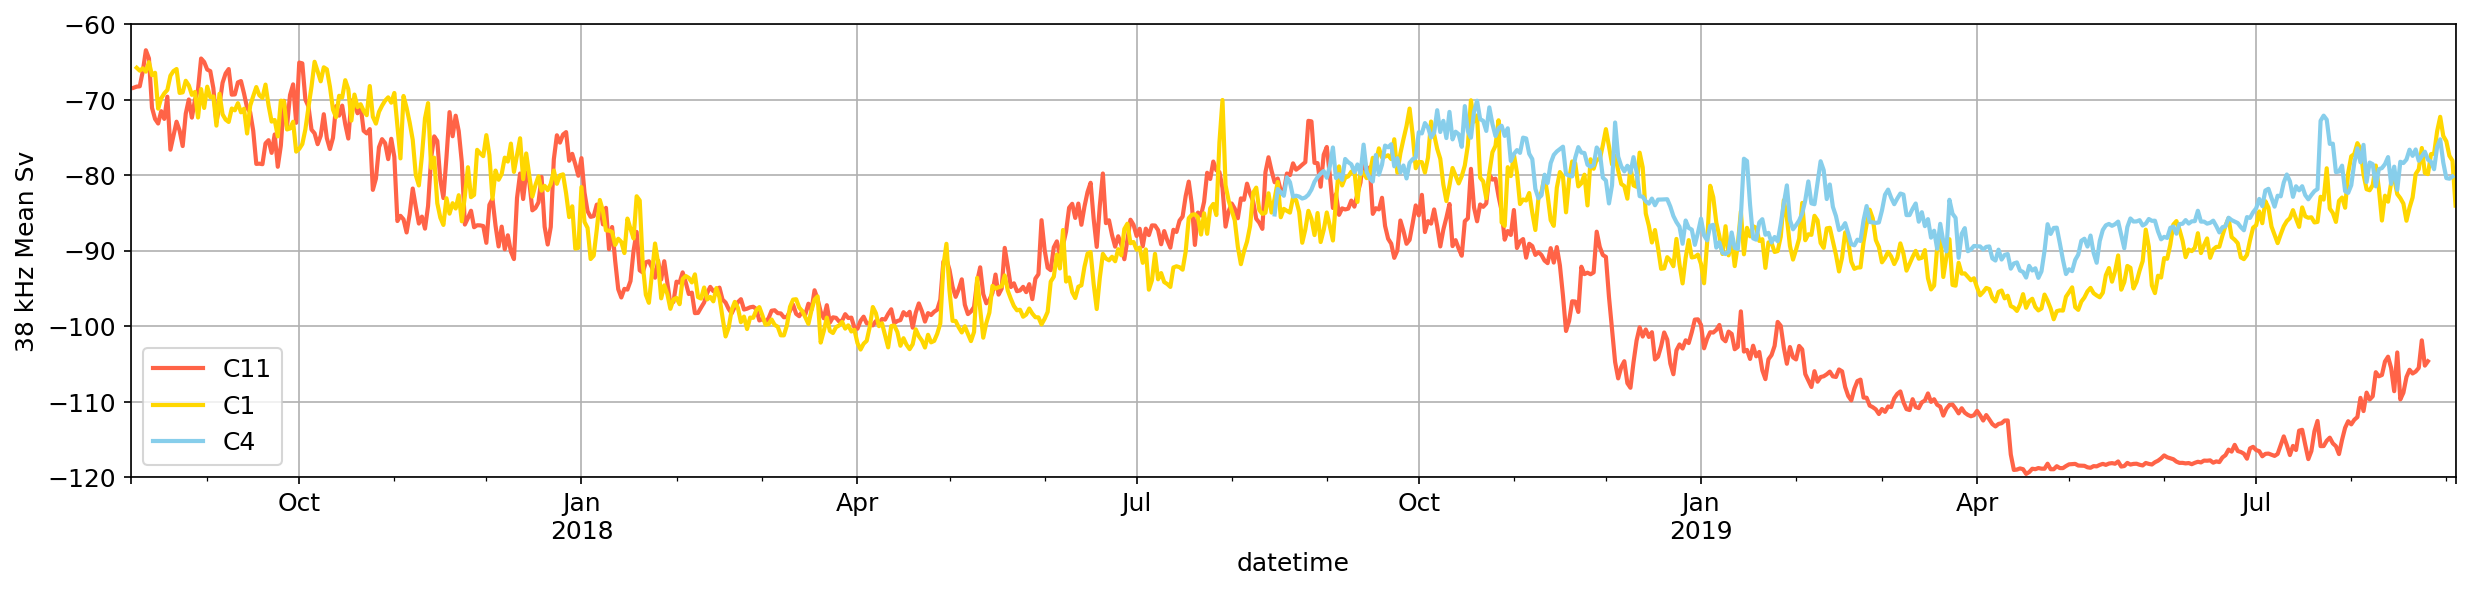

In [163]:

#pltDict = {'D1':[0,0,10000],'D2':[0,0,10000],'D3':[1,0,3000]}
f, (ax1)= plt.subplots(1,1,figsize=(20,4),sharex=True, sharey=True,dpi=150)

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/DAFT1/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/DAFT1/exports/1m/38*.csv')))
ax1=plt.subplot(111)
a = df['Sv'].resample('2H').mean()
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='tomato')

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/DAFT2/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/DAFT2/exports/1m/38*.csv')))
a = df['Sv'].resample('2H').mean()
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='gold')

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/DAFT3/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/DAFT3/exports/1m/38*.csv')))
a = df['Sv'].resample('2H').mean()
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='skyblue')

ax1.set_ylim([-120,-60])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.legend(['C11','C1','C4'])#,loc = 'lower left')
plt.ylabel('38 kHz Mean Sv')


# Time series review

Text(0, 0.5, '200 kHz Mean Sv')

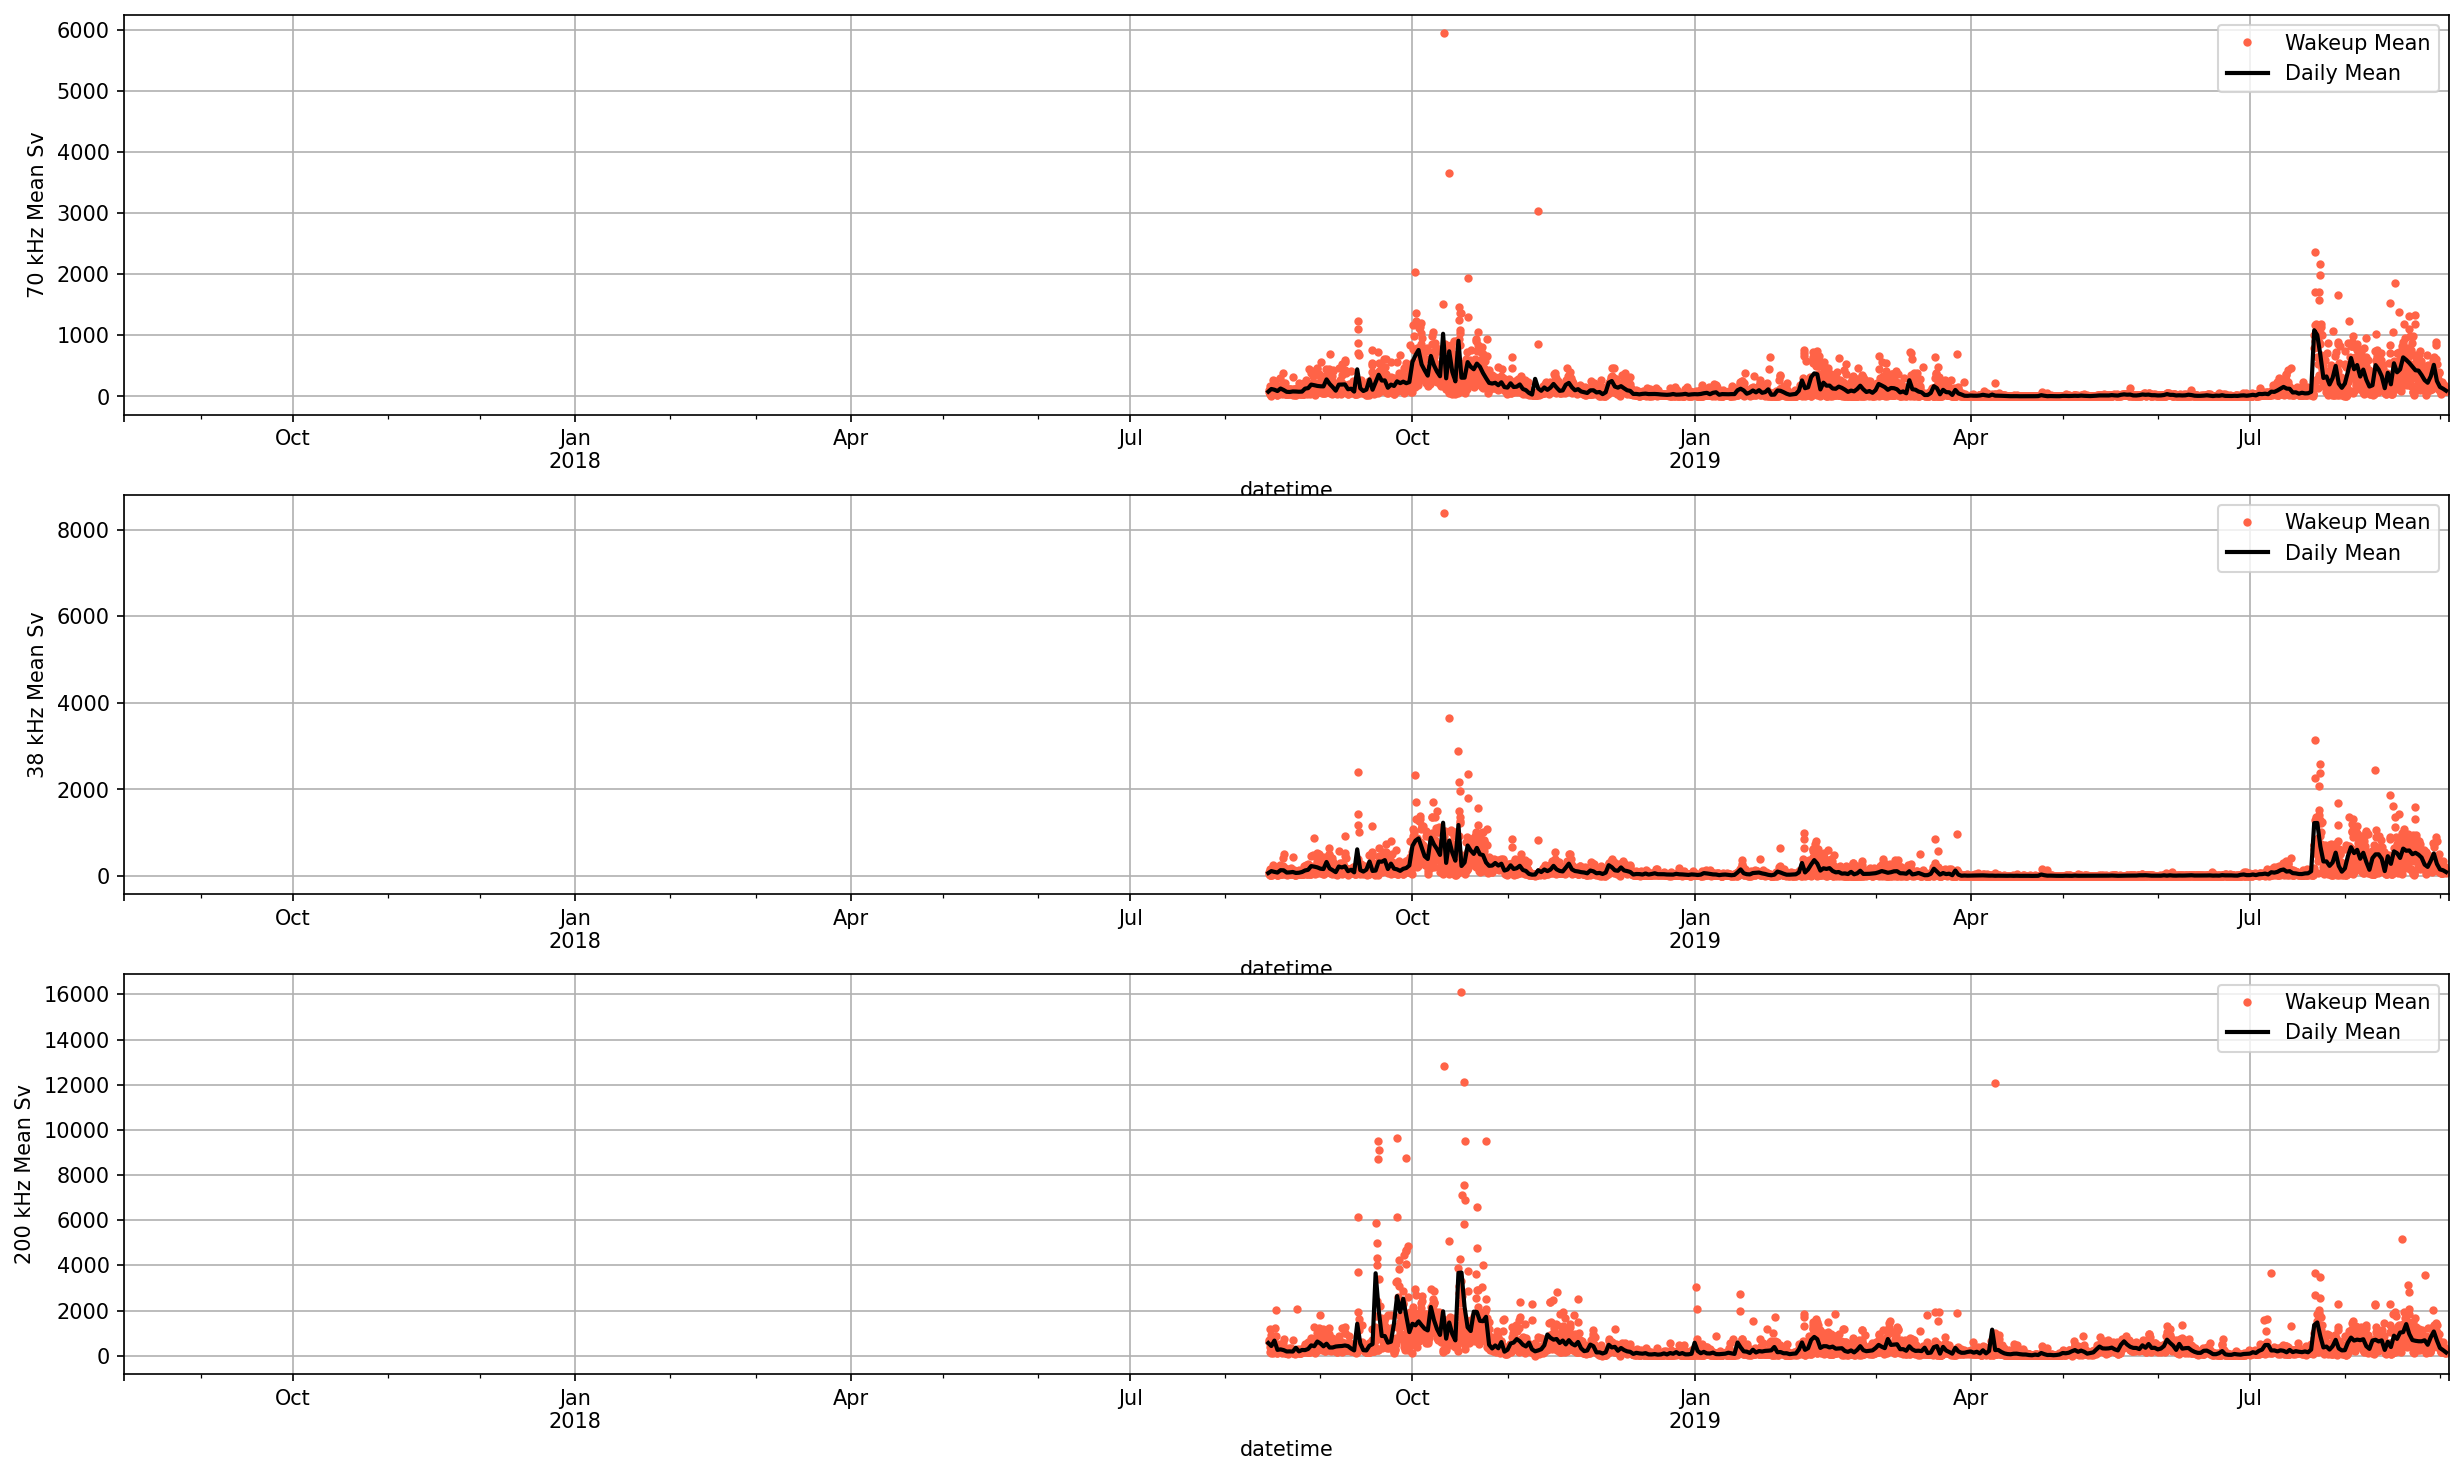

In [262]:
daft = 'DAFT3'

#pltDict = {'D1':[0,0,10000],'D2':[0,0,10000],'D3':[1,0,3000]}
f, (ax1,ax2,ax3)= plt.subplots(3,1,figsize=(20,12),sharex=True, sharey=True,dpi=150)

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
ax1=plt.subplot(311)
a = df['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')

#ax1.set_ylim([-60,1000])
#ax1.set_yticks([0,1000,2000,3000])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.legend(['Wakeup Mean','Daily Mean'])#,loc = 'lower left')
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
plt.ylabel('70 kHz Mean Sv')


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
ax1=plt.subplot(312)
a = df['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')

#ax1.set_ylim([-60,1000])
#ax1.set_yticks([0,1000,2000,3000])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.legend(['Wakeup Mean','Daily Mean'])#,loc = 'lower left')
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
plt.ylabel('38 kHz Mean Sv')


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
ax1=plt.subplot(313)
a = df['sA'].resample('2H').sum()
a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.resample('D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='k')

#ax1.set_ylim([-60,1000])
#ax1.set_yticks([0,1000,2000,3000])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.legend(['Wakeup Mean','Daily Mean'])#,loc = 'lower left')
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
plt.ylabel('200 kHz Mean Sv')

In [ ]:
freq = '200'
df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/'+freq+'*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/'+freq+'*.csv')))
a = df.resample('2H').sum()
sortedDf = a.sort_values(['sA'], ascending=False)
#sortedDf = df.sort_values(['Sv'], ascending=False)
sortedDf.drop_duplicates().head(30)

In [110]:
import itertools
rerun = ['20190402','20181203']

daft = 'DAFT3'
depth = 1
#year = '2018'
#calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C1_17_18.ecs'
year = '2019'
calFile = 'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C4_18_19.ecs'

files = []
for a in rerun:
    files.append(glob('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\*'+a+'*.EV'))
files = list(itertools.chain.from_iterable(files))
if len(files)>0:
    a = evExporterMooringMod(files,year,daft,depth,calFile)

2019   DAFT3
File 70 Exported. Total time: 0m 9s
File 38 Exported. Total time: 0m 12s
File 200 Exported. Total time: 0m 16s
File 70 Exported. Total time: 0m 9s
File 38 Exported. Total time: 0m 12s
File 200 Exported. Total time: 0m 16s
Done


# Summary figure

<ipython-input-317-54004cb15c1a>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(311)
<ipython-input-317-54004cb15c1a>:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(312)
<ipython-input-317-54004cb15c1a>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created

Text(0, 0.5, '200 kHz s$_{A}$')

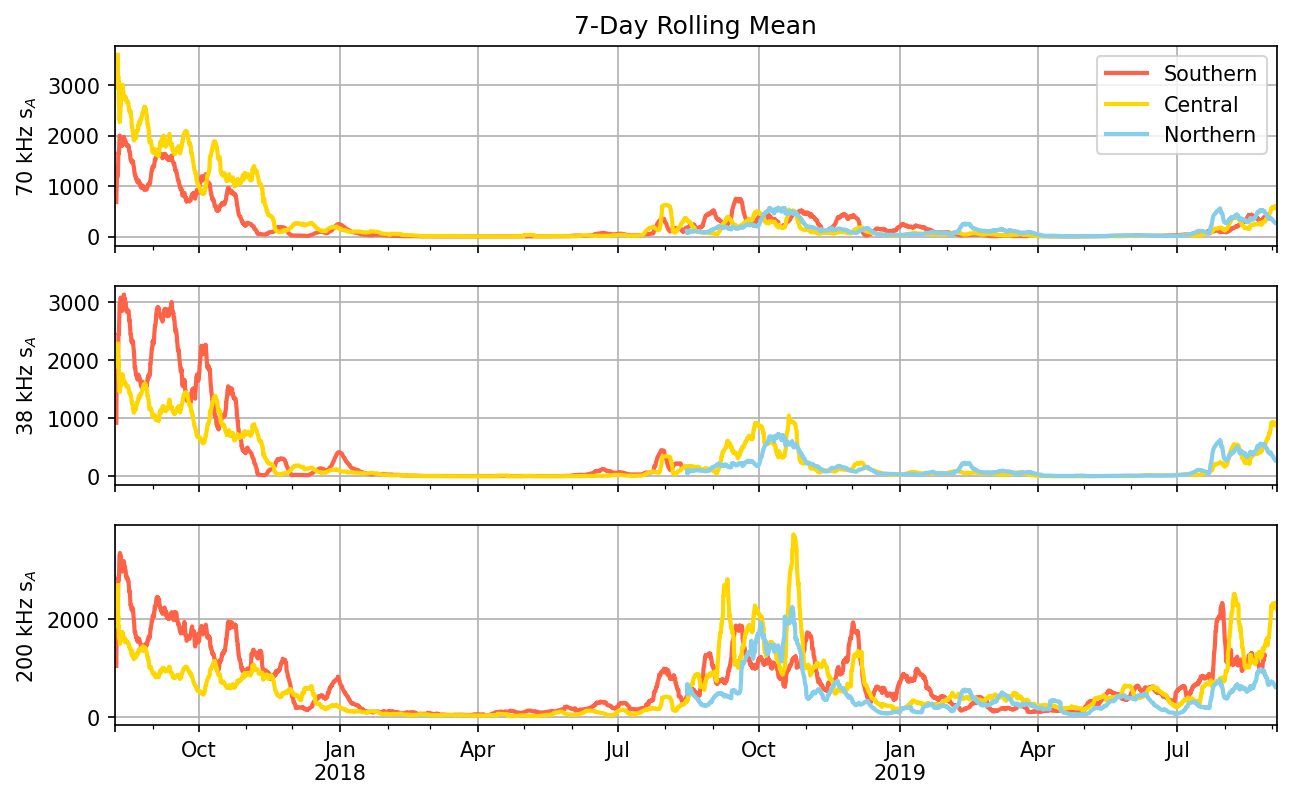

In [317]:
f, (ax1,ax2,ax3)= plt.subplots(3,1,figsize=(10,6),sharex=True, sharey=True,dpi=150)

daft = 'DAFT1'
df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
ax1=plt.subplot(311)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='tomato')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv')))
ax1=plt.subplot(312)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='tomato')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
ax1=plt.subplot(313)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='tomato')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)

daft = 'DAFT2'
df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
ax1=plt.subplot(311)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='gold')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
ax1=plt.subplot(312)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='gold')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)

df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
ax1=plt.subplot(313)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='gold')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)

daft='DAFT3'
df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
ax1=plt.subplot(311)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='skyblue')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.legend(['Southern','Central','Northern'])#,loc = 'lower left')
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.ylabel('70 kHz s$_{A}$')
plt.title('7-Day Rolling Mean')


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
ax1=plt.subplot(312)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='skyblue')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
ax1.set_xticklabels([])
ax1.xaxis.label.set_visible(False)
plt.ylabel('38 kHz s$_{A}$')


df = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
ax1=plt.subplot(313)
a = df['sA'].resample('2H').sum()
#a.plot( style='.',label='Wakeups',legend=False,axes=ax1, color='tomato')
a.rolling('7D').mean().plot(legend=False,label='Daily Mean', axes=ax1,linewidth=2,color='skyblue')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax1.grid()
#ax1.set_xticklabels([])
#ax1.xaxis.label.set_visible(False)
plt.ylabel('200 kHz s$_{A}$')

In [159]:
?plt.gca().colormesh

Object `plt.gca().colormesh` not found.


<ipython-input-189-e220dc44a4cc>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['0','10','20'])


[Text(0, 0.925, '0'),
 Text(0, 0.9500000000000001, '10'),
 Text(0, 0.9750000000000001, '20'),
 Text(0, 1.0, ''),
 Text(0, 1.0250000000000001, ''),
 Text(0, 1.05, ''),
 Text(0, 1.0750000000000002, '')]

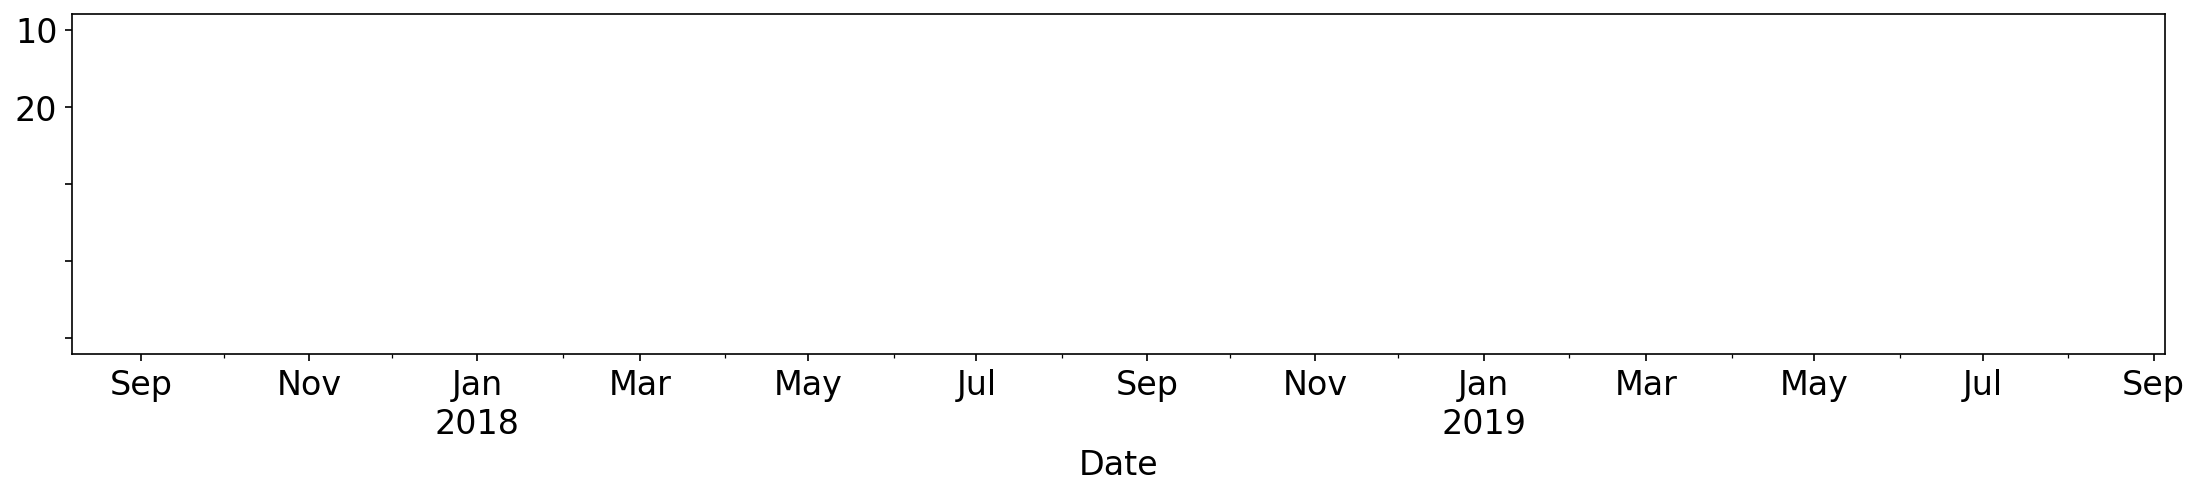

In [189]:
import matplotlib.dates as mdates
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
a = pd.date_range(start = '2017-8-8', end='2019-09-05', freq='2H')
b = pd.DataFrame({'datetime':a,'test':1})
b.test.plot()
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-09-05')])
ax1.invert_yaxis()
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
ax1.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax1.xaxis.set_major_formatter(maj_fmt)
ax1.set_xlabel('Date')
ax1.set_yticklabels(['0','10','20'])

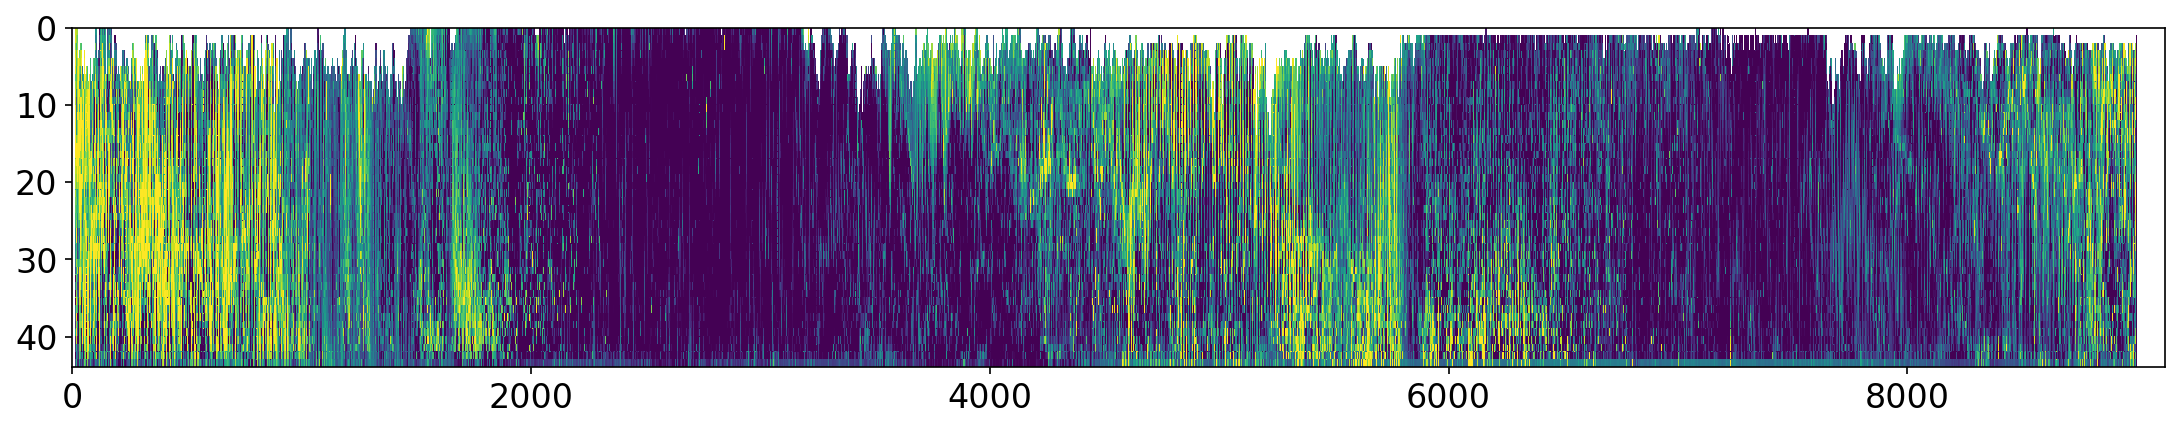

In [322]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT1','Sv')
heatmap = ax1.pcolormesh(piv70, cmap=plt.cm.viridis,vmin=-90, vmax=-60)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

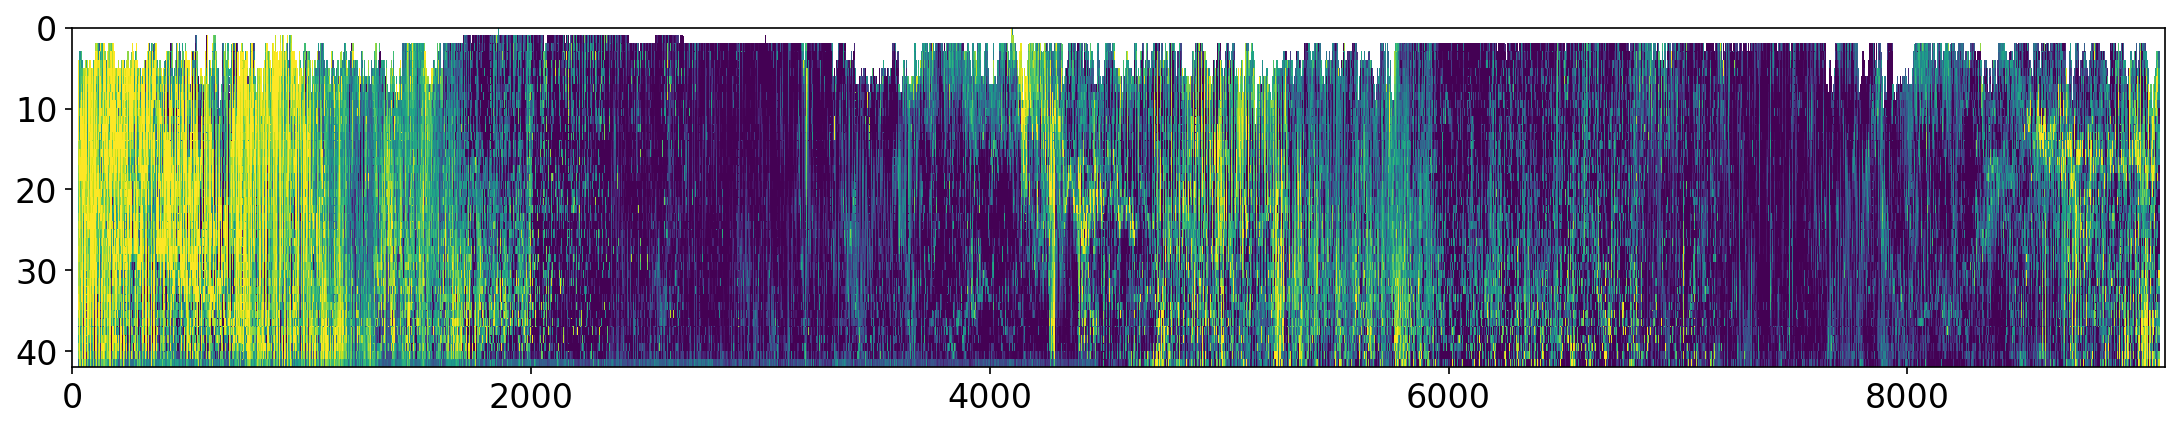

In [323]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT2','Sv')
heatmap = ax1.pcolormesh(piv70, cmap=plt.cm.viridis,vmin=-90, vmax=-60)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

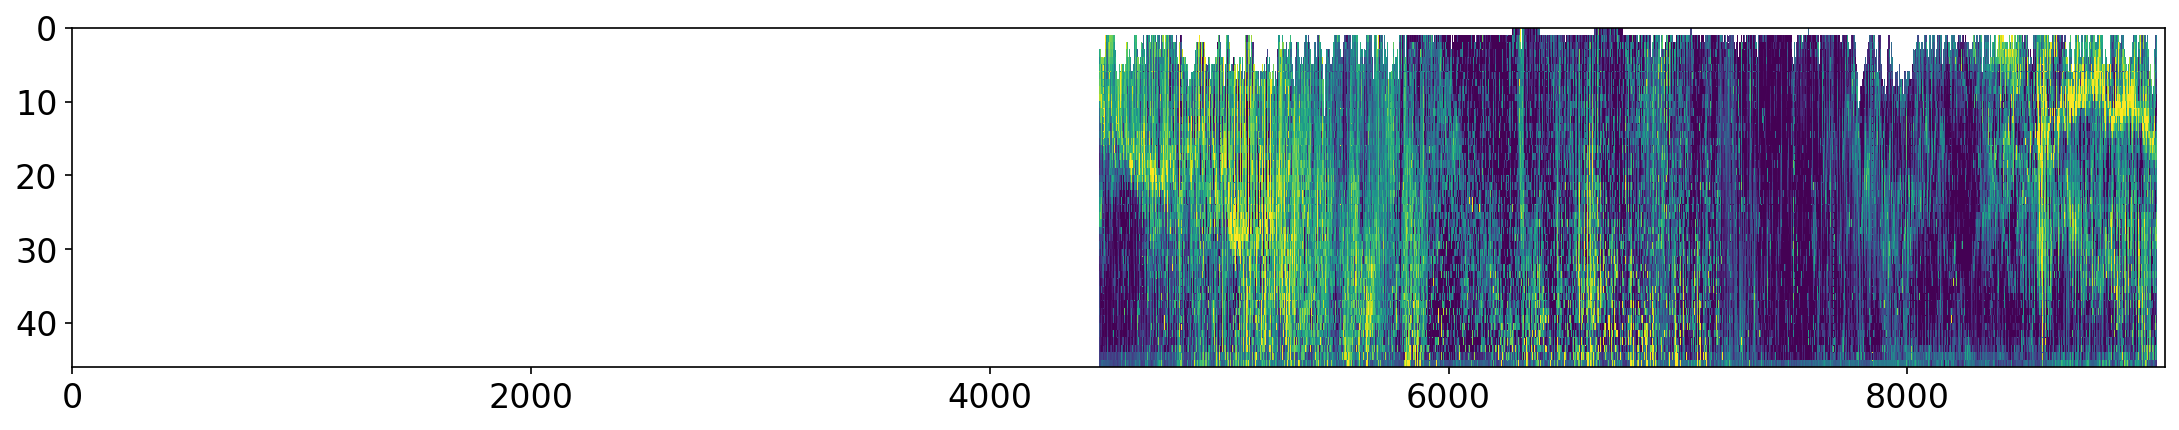

In [324]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT3','Sv')
heatmap = ax1.pcolormesh(piv70, cmap=plt.cm.viridis,vmin=-90, vmax=-60)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

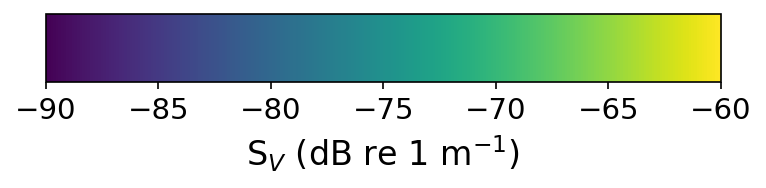

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3),dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.viridis
#cmap = clr.LinearSegmentedColormap.from_list('acod',['#808080','#800080','#b300b3','#ff00ff'], N=256)
#cmap = clr.LinearSegmentedColormap.from_list('acod',['#808080','#008000','#00b300','#00ff00'], N=256)
norm = mpl.colors.Normalize(vmin=-90, vmax=-60)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
#cb1.set_label('Pollock m$^{-2}$',fontsize=16,labelpad=-15)
cb1.set_label('S$_{V}$ (dB re 1 m$^{-1}$)',fontsize=16)
#cb1.set_ticks([0,1,2,3])
#cb1.set_ticklabels(['-90','1','2','> 3'])
cb1.ax.tick_params(labelsize=14)

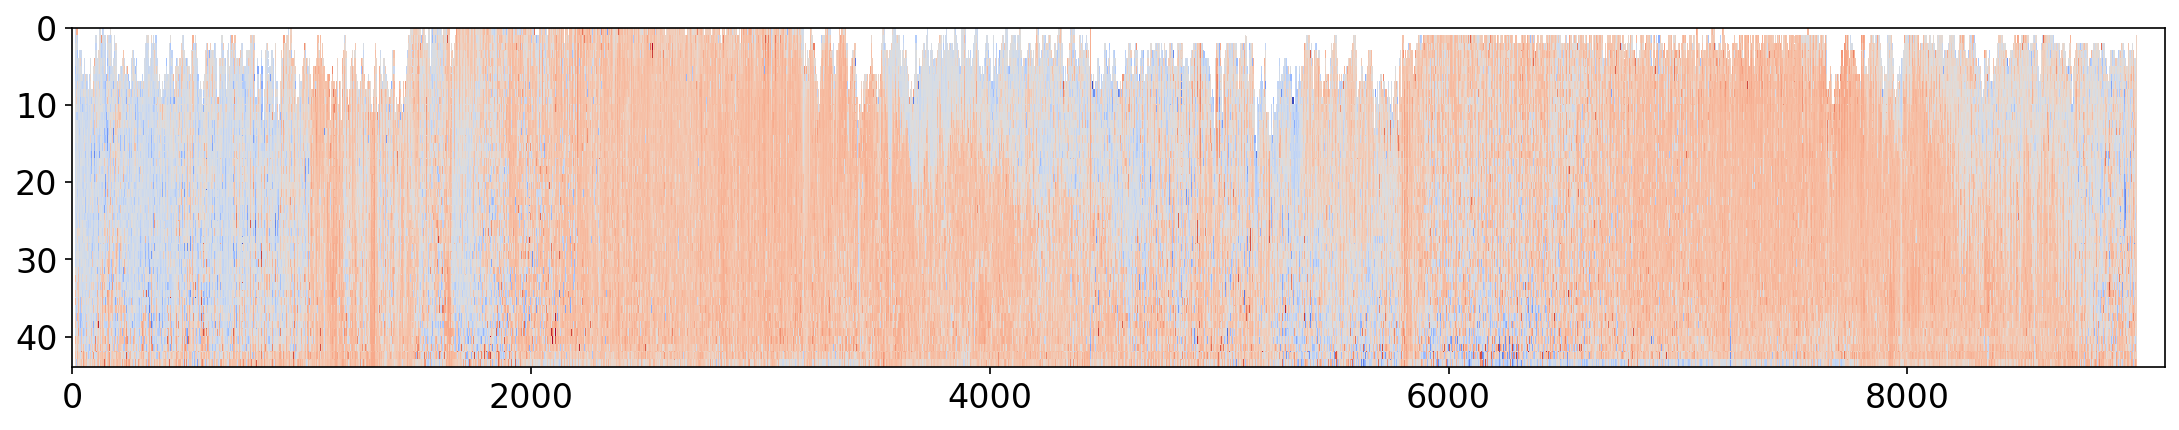

In [325]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT1','sA')
heatmap = ax1.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

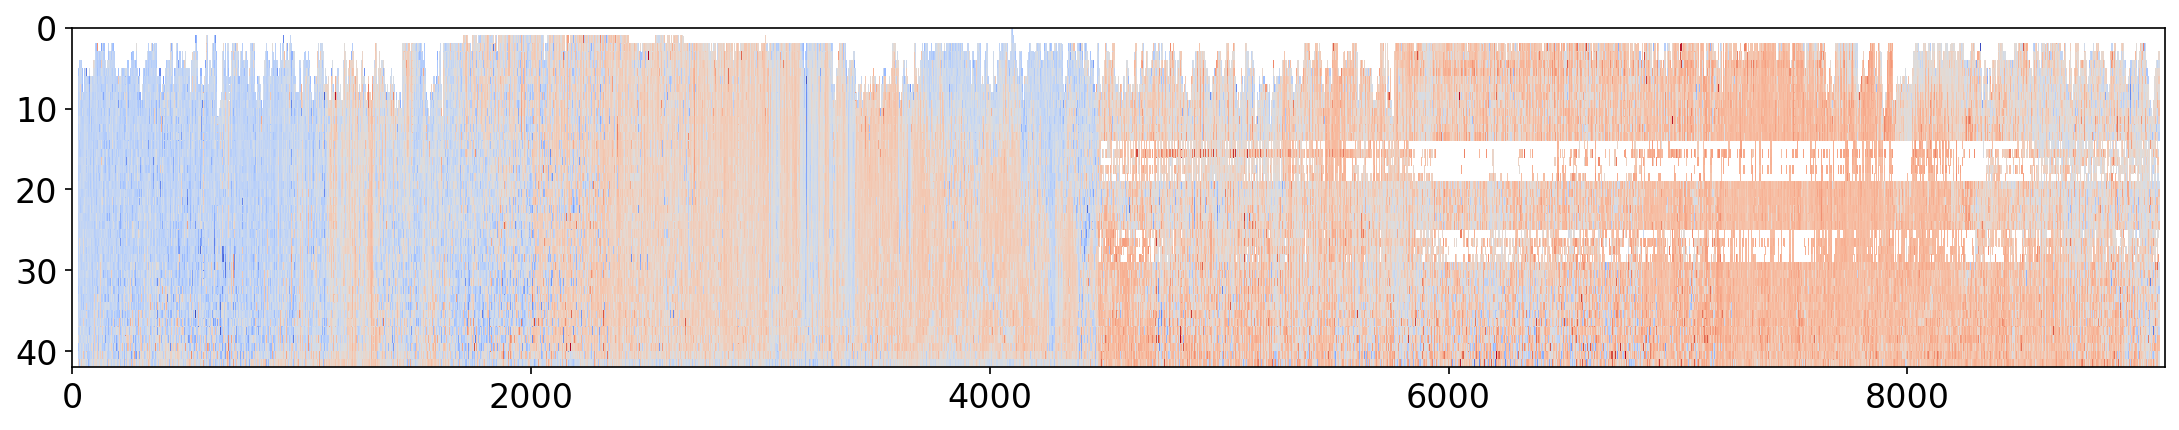

In [326]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT2','sA')
heatmap = ax1.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

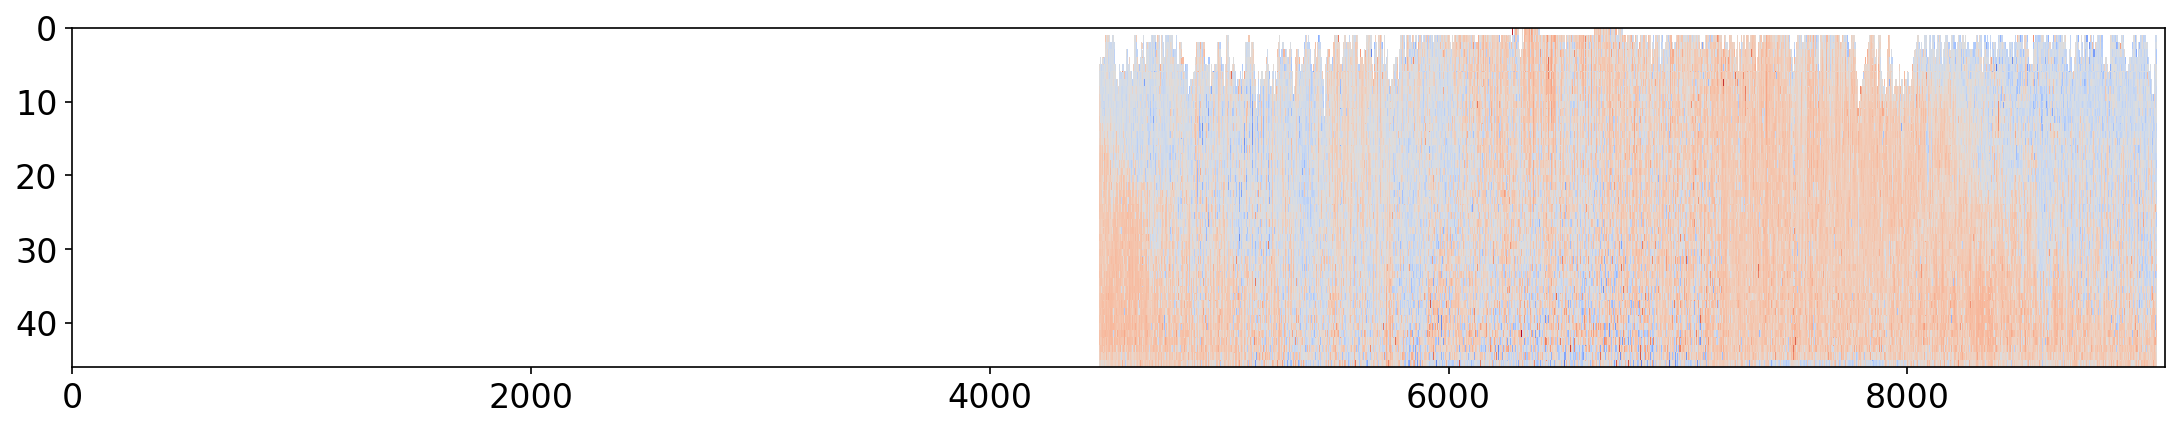

In [327]:
fig, (ax1) = plt.subplots(1,figsize=(18,3), dpi= 150)
plt.rcParams.update({'font.size':16})
piv70,piv38,piv200 = daftPivot('DAFT3','sA')
heatmap = ax1.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax1.invert_yaxis()
#fig.colorbar(heatmap, ax=ax1)

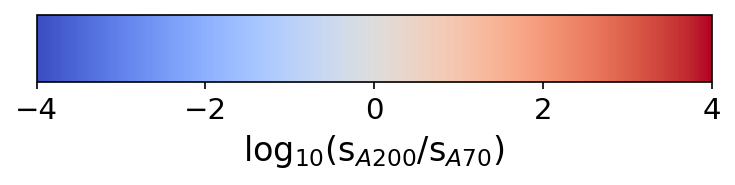

In [111]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3),dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.coolwarm
#cmap = clr.LinearSegmentedColormap.from_list('acod',['#808080','#800080','#b300b3','#ff00ff'], N=256)
#cmap = clr.LinearSegmentedColormap.from_list('acod',['#808080','#008000','#00b300','#00ff00'], N=256)
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
#cb1.set_label('Pollock m$^{-2}$',fontsize=16,labelpad=-15)
cb1.set_label('log$_{10}$(s$_{A200}$/s$_{A70}$)',fontsize=16)
#cb1.set_ticks([0,1,2,3])
#cb1.set_ticklabels(['-90','1','2','> 3'])
cb1.ax.tick_params(labelsize=14)

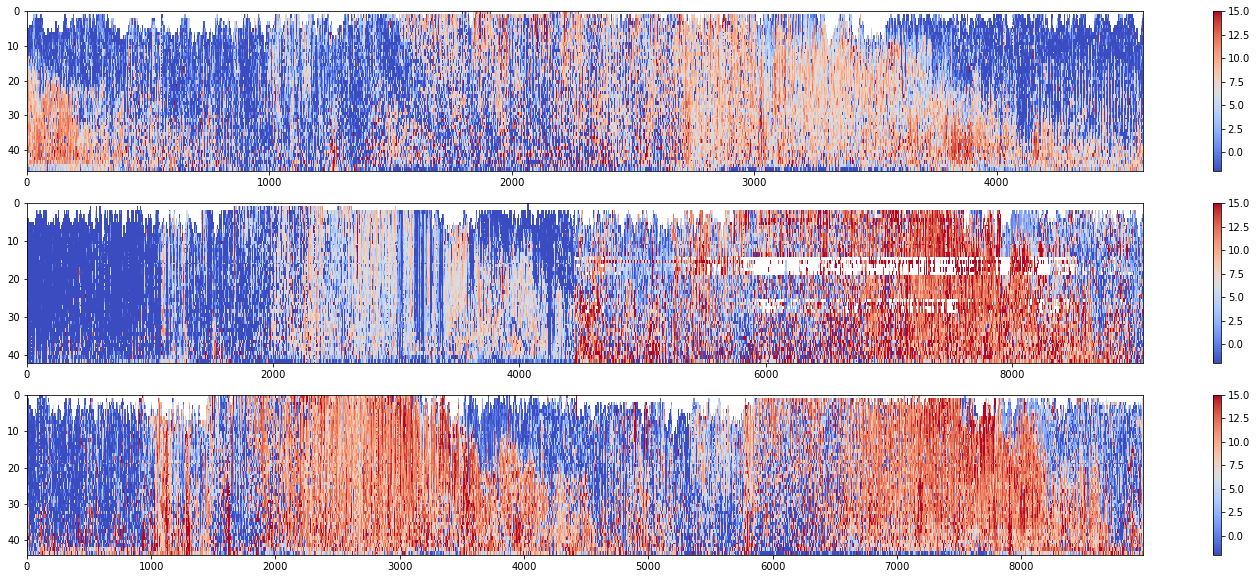

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(25,10))
piv70,piv38,piv200 = daftPivot('DAFT3','Sv')
heatmap = ax1.pcolormesh(piv200-piv70, cmap=plt.cm.coolwarm,vmin=-2, vmax=15)
ax1.invert_yaxis()
fig.colorbar(heatmap, ax=ax1)
piv70,piv38,piv200 = daftPivot('DAFT2','Sv')
heatmap = ax2.pcolormesh(piv200-piv70, cmap=plt.cm.coolwarm,vmin=-2, vmax=15)
ax2.invert_yaxis()
fig.colorbar(heatmap, ax=ax2)
piv70,piv38,piv200 = daftPivot('DAFT1','Sv')
heatmap = ax3.pcolormesh(piv200-piv70, cmap=plt.cm.coolwarm,vmin=-2, vmax=15)
ax3.invert_yaxis()
fig.colorbar(heatmap, ax=ax3)

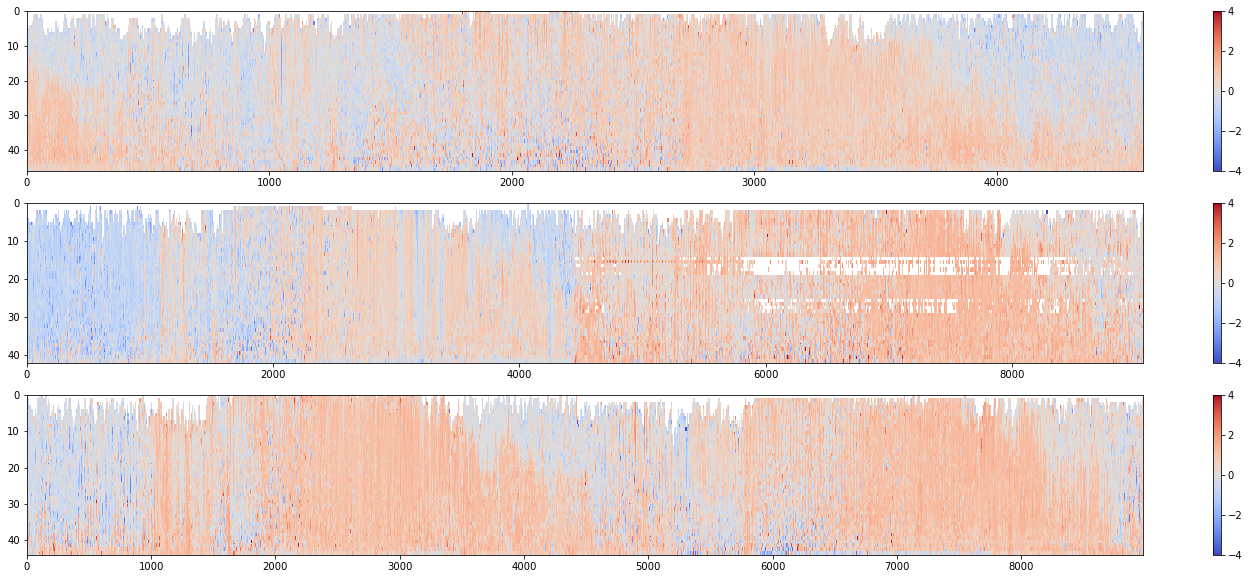

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(25,10))
piv70,piv38,piv200 = daftPivot('DAFT3','sA')
heatmap = ax1.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax1.invert_yaxis()
fig.colorbar(heatmap, ax=ax1)
piv70,piv38,piv200 = daftPivot('DAFT2','sA')
heatmap = ax2.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax2.invert_yaxis()
fig.colorbar(heatmap, ax=ax2)
piv70,piv38,piv200 = daftPivot('DAFT1','sA')
heatmap = ax3.pcolormesh(np.log10(piv200/piv70), cmap=plt.cm.coolwarm,vmin=-4, vmax=4)
ax3.invert_yaxis()
fig.colorbar(heatmap, ax=ax3)

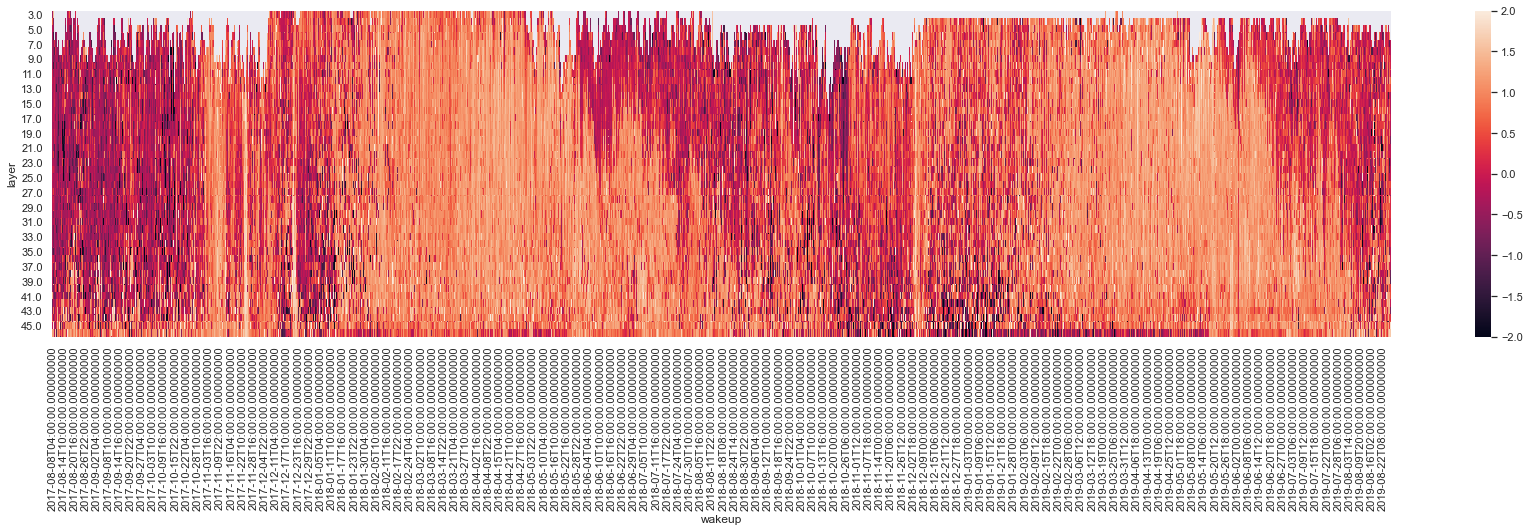

In [112]:
piv70,piv38,piv200 = daftPivot('DAFT1','sA')
import seaborn as sns
from datetime import datetime, timedelta
import random
import matplotlib.dates as mdates

fig, ax = plt.subplots(1,figsize=(30,6))
sns.set()
ax = sns.heatmap(np.log10(piv200/piv70), vmin=-2, vmax=2)

plt.show()

In [71]:
daft='DAFT3'
dfD1_70 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
dfD1_38 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
dfD1_200 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
dfD1_70['wakeup'] = pd.to_datetime(dfD1_70.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
dfD1_38['wakeup'] = pd.to_datetime(dfD1_38.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
dfD1_200['wakeup'] = pd.to_datetime(dfD1_200.index.map(lambda x: x.strftime('%Y-%m-%d %H')))

In [ ]:
import seaborn as sns
from datetime import datetime, timedelta
import random
import matplotlib.dates as mdates

fig, ax = plt.subplots(1,figsize=(30,6))
sns.set()
ax = sns.heatmap(np.log10(piv200/piv70), vmin=-2, vmax=2)
ax.set_xticklabels()
ax.set_xticklabels(ax.get_xticklabels().dt.strftime('%d-%m-%Y'))
#plt.xticks(rotation=-90)

maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

plt.show()